In [34]:
import pandas as pd
import numpy as np
import nltk
import re
import string
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pyexpat import model
import pandas as pd
from scripts.util import  join_text, clean_text,tokenize, calculate_word_freq
from sklearn.model_selection import train_test_split
from scripts.nlp_func import build_w2v_model, build_model, build_d2v_model, evaluate_model, plot_confusion_matrix
import gensim
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from scripts.util import clean_text
import gensim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
from sklearn.metrics import confusion_matrix
import glob
nltk.download('words')
words = set(nltk.corpus.words.words())
stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package words to
[nltk_data]     /home/canfang_linux/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


## Business understanding

Spam is unsolicited and unwanted messages sent electronically whose content may be malicious. The danger could be: exposure of pravicy, a fraud, or a virus,etc. It is a major problem for email and mobine phone users, and it is a growing problem for social media users like Youtube users. We need a solution to detect spam comments. Before that, we need to understand what kinds of Youtube author leave the spam comments most? what are the common words and pattern in the Youtube spam messages? Is it any possible for us to build a model to detect spam messages?  

## Data understanding

The dataset is from [kaggle datasets: Youtube SPAM Classified-comments](https://www.kaggle.com/datasets/goneee/youtube-spam-classifiedcomments?select=Youtube03-LMFAO.csv). It contains 5 csv files with a total of 1956 Youtube messages. The dataset is a collection of more than 1615 Youtube authors. It is a public available dataset for research. The data is labeled, which means each message is labeled as spam or ham. Original dataset has some nosisy information, e.g. missing value in date, and some messages are not in English and unknowd words. The dataset need to be cleaned and preprocessed for further analysis.


## Access and explore the data

Only query the first two columns data, and assign the columns name as "label" and "text", remove the Unwanted columns.

In [19]:
# function to read the csv file starting with Youtube
def read_csv_files(keyword):
    df = pd.DataFrame()
    for file in glob.glob("data/*.csv"):
        if keyword in file:
            df = df.append(pd.read_csv(file, index_col=None, header=0))
    return df

df=read_csv_files("Youtube")
df=df.rename(columns={"CONTENT": "text", "CLASS": "label", "AUTHOR": "author", "DATE": "date", "COMMENT_ID": "id"})

In [20]:
print(f"Shape of the dataset: {df.shape}")
print(f"samples of the dataset: {df.head()}")

Shape of the dataset: (1956, 5)
samples of the dataset:                                       id        author  \
0  z13uwn2heqndtr5g304ccv5j5kqqzxjadmc0k  Corey Wilson   
1  z124jvczaz3dxhnbc04cffk43oiugj25yzo0k   Epic Gaming   
2      z13tczjy5xj0vjmu5231unho1ofey5zdk     LaS Music   
3  z13tzr0hdpnayhqqc04cd3zqqqjkf3ngckk0k    Cheryl Fox   
4  z12pcvix4zedcjvyb04ccr1r0mr2g5xwyng0k    PATRICK_TW   

                         date  \
0  2015-05-28T21:39:52.376000   
1  2015-05-28T20:07:20.610000   
2  2015-05-28T19:23:35.355000   
3  2015-05-28T17:49:35.294000   
4  2015-05-28T16:28:26.818000   

                                                text  label  
0  <a href="http://www.youtube.com/watch?v=KQ6zr6...      0  
1                                   wierd but funny﻿      0  
2  Hey guys, I&#39;m a human.<br /><br /><br />Bu...      1  
3       Party Rock....lol...who wants to shuffle!!!﻿      0  
4                                        Party rock﻿      0  


Check the null values in the dataset

In [21]:
df.isna().sum()

id          0
author      0
date      245
text        0
label       0
dtype: int64

There is 245 missing value in date column, and 0 missing value in the other columns. For those missing values, we can drop them.

In [22]:
df.dropna(inplace=True)

Clean the text by removing punctuation, lowercasing, removing stopwords and stemming.

In [71]:
def clean_tokenize(text):
    """
    Tokenizes the text.
    Args:
        text: The text to tokenize.
    Returns:
        tokens: The tokens of the text.
    """

    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    clean_tokens = [
        lemmatizer.lemmatize(w) for w in tokens if w not in stopwords and w in words
    ]

    return clean_tokens

df['clean_text'] = df['text'].apply(lambda x: clean_tokenize(x))
df['clean_text'].head()

0                               [watch, v, best, part]
1                                              [funny]
2    [hey, human, want, human, want, sexy, giraffe,...
3                               [party, rock, shuffle]
4                                        [party, rock]
Name: clean_text, dtype: object

Exploration: how many spam and ham messages are there?

In [37]:
counts=df.label.value_counts()
ham_ratio=round(counts[0]/counts.sum(),2)
spam_ratio=round(counts[1]/counts.sum(),2)
print(counts)
print(f"This is balanced data. The ratio of ham to spam is {ham_ratio}:{spam_ratio}")


0    951
1    760
Name: label, dtype: int64
This is balanced data. The ratio of ham to spam is 0.56:0.44


### Question 1: Who leaves the most spam commnets? Which authors should be flagged as warning? Were they more active in weekdays or weekends?


In [66]:
df.author.value_counts(), df[df.label==1].author.value_counts()

(Shadrach Grentz     7
 5000palo            7
 Hidden Love         5
 LuckyMusiqLive      5
 James Cook          4
                    ..
 John Wilkie         1
 Ayano Hattori       1
 Trollsif Stalin     1
 Camila Rodrigues    1
 Ray Benich          1
 Name: author, Length: 1615, dtype: int64,
 Shadrach Grentz    7
 Hidden Love        5
 LuckyMusiqLive     5
 James Cook         4
 macgyver16         3
                   ..
 JH Simene          1
 Syed Akbar Ali     1
 Alexander Solli    1
 rtfamily           1
 Photo Editor       1
 Name: author, Length: 694, dtype: int64)

In this dataset, we can see Shadrach Grentz,5000palo are the top 2 authors who have the most comments. Among all the authors,  Shadrach Grentz, Hidden Love, LuckyMusiqLive, etc. leave the most spam comments. 

In [69]:
df['date'] = pd.to_datetime(df['date'])
# get weekday from date
df['weekday']=df['date'].dt.day_name()
df[df.label==1].weekday.value_counts()

Saturday     131
Thursday     130
Sunday       110
Friday        99
Monday        98
Tuesday       97
Wednesday     95
Name: weekday, dtype: int64

Suppringly, the spam comments are more likely to be posted on weekends.

### Question 2: What kinds of words used most in spam comment, where our youtube users pay more attention to?

Create utility function to calculate the word frequency

In [45]:
def join_text(text):
    """
    Join the list of words into a string separated by space, and return the result.
    """
    return " ".join(text)


def calculate_word_freq(text, tokenizer):
    """
    Calculate the frequency of each word in the text, and return the result as a list of tuples.
    Args:
        text: The text to calculate the word frequency.
        tokenizer: The tokenizer to use.
    Returns:
        word_freq: The word frequency of the text.
    """
    clean_text = clean_tokenize(text)
    freq = {}  # stores the frequency of elements
    for x in clean_text:
        freq[x] = clean_text.count(x)

    sort_word = pd.DataFrame(freq.items(), columns=["Word", "Frequency"]).sort_values(
        by="Frequency", ascending=False
    )
    return sort_word


words frequency in spam messages

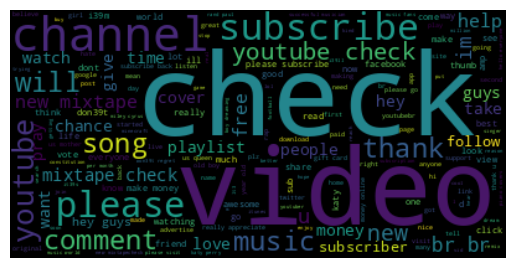

In [46]:
# join all the spam messages into one text 
spam_text= "".join([word.lower() for word in join_text(df[df.label==1].text) if word not in string.punctuation])
# create the word cloud
wordcloud=WordCloud().generate(spam_text)
# plot the word cloud
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Top 25 Spam Words')

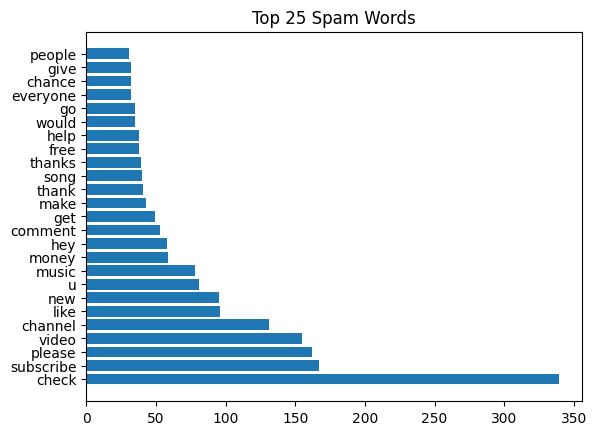

In [47]:
# calculate each words frequency in spam text
sort_spam_word=calculate_word_freq(spam_text,clean_text)
# get the top 25 words and visualize them in the bar chart
top_N=25
plt.barh(sort_spam_word['Word'][:top_N], sort_spam_word['Frequency'][:top_N])
plt.title(f"Top {top_N} Spam Words")

According to the wordcloud diagram and bar chart, we can see that spam messages tend to use more words like “check”, “subsribe”, “channel”, “money”, "ike” etc. Those texts urge the receiver to take action.

Words frequency in ham messages

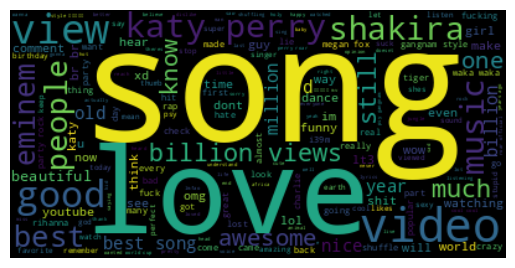

In [48]:
# join all the ham messages into one text 
ham_text= "".join([word.lower() for word in join_text(df[df.label==0].text) if word not in string.punctuation])
# create the word cloud of ham messages
wordcloud=WordCloud().generate(ham_text)
# plot the word cloud
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Top 25 ham Words')

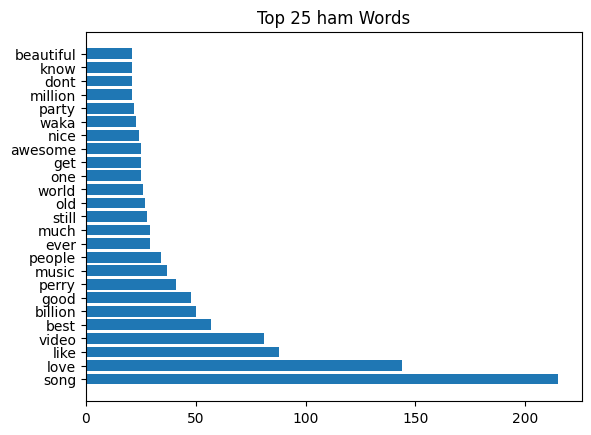

In [49]:
# calculate each words frequency in ham text
sort_ham_word=calculate_word_freq(ham_text,clean_text)
# get the top 25 words and visualize them in the bar chart
top_N=25
plt.barh(sort_ham_word['Word'][:top_N], sort_ham_word['Frequency'][:top_N])
plt.title(f"Top {top_N} ham Words")

In comparison, for the ham word cloud and bar chart, those neutral verb words like “song”,”love”,”like”,”video” etc. are used mostly, more about sharing and enjoying the video.

## Question 3: Is it any possible for us to build a model to detect spam messages?  

Randomly split the data into training and testing sets,since the dataset is small, we use 80% for training and 20% for testing.

In [51]:
X_train, X_test, y_train, y_test_clean = train_test_split(
    df["clean_text"], df["label"], test_size=0.2, random_state=42
)
print(f" X_train shape: {X_train.shape}", f" X_test shape: {X_test.shape}")
print(f" y_train shape: {y_train.shape}", f" y_test shape: {y_test_clean.shape}")
print(f" y_train spam ratio: {round(y_train.sum()/y_train.shape[0],2)}")
print(f" y_test spam ratio: {round(y_test_clean.sum()/y_test_clean.shape[0],2)}")

 X_train shape: (1368,)  X_test shape: (343,)
 y_train shape: (1368,)  y_test shape: (343,)
 y_train spam ratio: 0.44
 y_test spam ratio: 0.45


### build model based on word2vec and evaluate its performance

Word2vec is a group of related models that are used to produce word embeddings. Word embeddings are an approach to provide a dense representation of words and their relative meanings. The word2vec model is a two-layer neural network that processes text. Its input is a text corpus and its output is a set of vectors: feature vectors for words in that corpus. The word2vec model is a shallow, two-layer neural network that is trained to reconstruct linguistic contexts of words. The model can be used to generate word embeddings that can be used in downstream natural language processing tasks.

In [52]:
# create a custom word2vec vectors transformer
class w2vTransformer(BaseEstimator, TransformerMixin):

    """
    Wrapper class for running word2vec into pipelines and FeatureUnions
    """

    def __init__(self, **kwargs):
        self.kwargs = kwargs

    def fit(self, X, y=None):
        # persist model for later use
        w2v_model = gensim.models.Word2Vec(X, vector_size=100, window=5, min_count=2)
        self.model = w2v_model
        return self

    def transform(self, X):
        X = X.copy()
        words = set(self.model.wv.index_to_key)
        X_vect = np.array(
            [np.array([self.model.wv[i] for i in ls if i in words]) for ls in X],
            dtype=object,
        )
        X_vect_avg = []
        for i in X_vect:
            if len(i) > 0:
                X_vect_avg.append(np.mean(i, axis=0))
            else:
                X_vect_avg.append(np.zeros(100))

        return np.array(X_vect_avg)

    def get_feature_names(self):
        return self.model.wv.index2word

    def get_params(self, deep=True):
        return {"model": self.model}


def build_w2v_model(estimator=RandomForestClassifier()):
    """
    Build a pipeline that includes:
        - w2vTransformer
        - RandomForestClassifier
    """
    pipeline = Pipeline(
        [
            ("w2v", w2vTransformer()),
            ("classifier", estimator),
        ]
    )
    return pipeline

In [53]:
# Train a classifier using the word2vec transformer and a random forest classifier
rf_word2vec_model = build_w2v_model()
print("Fitting word2vec model...")
rf_word2vec_model.fit(X_train, y_train)
y_pred_rf_word2vec = rf_word2vec_model.predict(X_test)

Fitting word2vec model...


### build model based on doc2vec 

doc2vec is an extension of word2vec that is specifically designed to work with documents. It is a shallow, two-layer neural network that is trained to reconstruct linguistic contexts of documents. The model can be used to generate document embeddings that can be used in downstream natural language processing tasks.

In [54]:
class d2vTransformer(BaseEstimator, TransformerMixin):

    """
    Wrapper class for running doc2vec into pipelines and FeatureUnions
    """

    def __init__(self, **kwargs):
        self.kwargs = kwargs

    def fit(self, X, y=None):
        # persist model for later use
        tagged_docs = [
            gensim.models.doc2vec.TaggedDocument(v, [i]) for i, v in enumerate(X)
        ]
        d2v_model = gensim.models.Doc2Vec(
            tagged_docs, vector_size=100, window=5, min_count=2
        )
        self.model = d2v_model

        return self

    def transform(self, X):
        tagged_docs_X = [
            gensim.models.doc2vec.TaggedDocument(v, [i]) for i, v in enumerate(X)
        ]
        X_vect = [self.model.infer_vector(eval(str(v.words))) for v in tagged_docs_X]

        return X_vect

    def get_feature_names(self):
        return self.model.docvecs.index2entity

    def get_params(self, deep=True):
        return {"model": self.model}


def build_d2v_model(estimator=RandomForestClassifier()):
    """
    Build a pipeline that includes:
        - w2vTransformer
        - RandomForestClassifier
    """
    pipeline = Pipeline(
        [
            ("w2v", d2vTransformer()),
            ("classifier", estimator),
        ]
    )
    return pipeline

In [55]:
# train a classifier using the doc2vec transformer and a random forest classifier
rf_doc2vec_model = build_d2v_model()
print("Fitting doc2vec model...")
rf_doc2vec_model.fit(X_train, y_train)
y_pred_rf_doc2vec = rf_doc2vec_model.predict(X_test)

Fitting doc2vec model...


### build model based on TF-IDF

TFIDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. TFIDF is one of the most popular term-weighting schemes today. A survey conducted in 2015 showed that 83% of text-based recommender systems in digital libraries use TFIDF.

In [56]:
def build_TFIDF_model():
    """
    Build a pipeline that includes:
        - TfidfVectorizer
        - RandomForestClassifier
    """
    pipeline = Pipeline(
        [
            ("tfidf", TfidfVectorizer(tokenizer=clean_text)),
            ("classifier", RandomForestClassifier(n_estimators=100)),
        ]
    )
    return pipeline


In [57]:
X_train, X_test, y_train, y_test_unclean = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42
)
rf_TFIDF_model = build_TFIDF_model()
rf_TFIDF_model.fit(X_train, y_train)
y_pred_rf_tfidf = rf_TFIDF_model.predict(X_test)

### How to choose the best model for business purpose?

 Here, we use precision, recall, and F1 score to evaluate the model performance. In addition, we use confusion matrix to visualize the model performance.

In [58]:
from sklearn.metrics import f1_score
def evaluate_model(y_test, y_pred):
    """
    Evaluate model performance
    Args:
        y_test: true labels
        y_pred: predicted labels
    Returns:
        None
    """
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_scores = f1_score(y_test, y_pred,average='weighted')
    print(
        "Precision: {} / Recall: {} / F1 score: {}".format(
            round(precision, 3),
            round(recall, 3),
            round(f1_scores, 3),
        )
    )

def plot_confusion_matrix(cm: np.array):
    """
    Plot confusion matrix
    Args:
        cm: confusion matrix
    Returns:
        None
    """
    fig, ax = plt.subplots(1, figsize=(4, 4))
    sns.heatmap(cm, annot=True, ax=ax, fmt="d", cmap="Blues")
    ax.set_title("Confusion matrix")
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    fig.tight_layout()
    plt.show()

Evaluate the performance of the model of word2vec on the test set

Evaluating model...
Precision: 0.892 / Recall: 0.744 / F1 score: 0.841


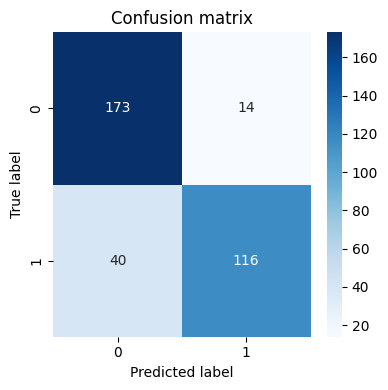

In [59]:
print("Evaluating model...")
evaluate_model(y_test_clean, y_pred_rf_word2vec)
# create confusion matrix
cm=confusion_matrix(y_test_clean,  y_pred_rf_word2vec)
plot_confusion_matrix(cm)

Evaluate the performance of the model of doc2vec on the test set

Evaluating model...
Precision: 0.775 / Recall: 0.442 / F1 score: 0.669


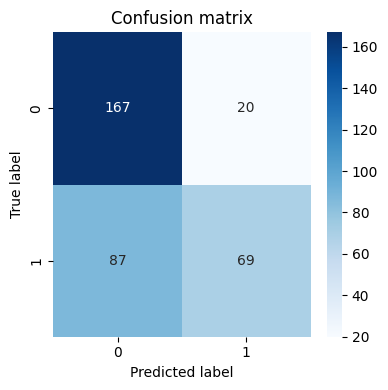

In [60]:
print("Evaluating model...")
evaluate_model(y_test_clean, y_pred_rf_doc2vec)
# create confusion matrix
cm=confusion_matrix(y_test_clean,  y_pred_rf_doc2vec)
plot_confusion_matrix(cm)



Evaluate the performance of the model of TFIDF on the test set

Evaluating model...
Precision: 0.949 / Recall: 0.833 / F1 score: 0.903


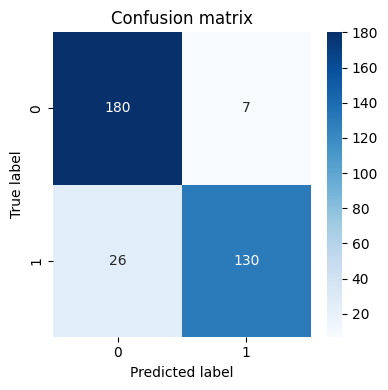

In [61]:
print("Evaluating model...")
evaluate_model(y_test_unclean, y_pred_rf_tfidf)
# create confusion matrix
cm=confusion_matrix(y_test_unclean,  y_pred_rf_tfidf)
plot_confusion_matrix(cm)

In comparison, the model based on TFIDF has the best performance. The precision, recall, and F1 score are all higher than the other two models. The confusion matrix also shows that the model based on TFIDF has the best performance. It can correct predict 97% of the spam messages, and 98% of the ham messages. We can save the model based on TFIDF for further business use.

In [86]:
# save the model into a pickle file
import pickle
pickle.dump(rf_TFIDF_model, open("model/model.pkl", "wb"))
